### Import Library

In [11]:
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [12]:
import sys
sys.path.append('../')

In [13]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

### Import Train and Test sets

In [14]:
train_set = pd.read_csv('6Hsampled_data_set/CNX/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/CNX/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/CNX/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

### Tuning Parameters

In [15]:
order = (2, 0, 1)
seasonal_order = (0, 1, 1, 1461)

exog_order = {}
exog_order['Temp'] = (2, 0, 2)
exog_order['WindSpeed'] = (1, 1, 0)
exog_order['WindDirSin'] = (2, 1, 0)
exog_order['WindDirCos'] = (2, 1, 0)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (1, 1, 1, 1461)
exog_seasonal_order['WindSpeed'] = (0, 1, 1, 1461)
exog_seasonal_order['WindDirSin'] = (0, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (0, 1, 0, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

### Initialize model

In [16]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

### Train exogenous models

In [17]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        n_iter = 1
        if exog=='WindSpeed': n_iter=10
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.999875, lr_decay_iter=0.95,
                                          step=12, n_iter=n_iter, learn=True, verbose=1)

100%|██████████| 4383/4383 [04:31<00:00, 16.15it/s]


ITER#0  RMSE:8.735589717620702


100%|██████████| 4383/4383 [04:28<00:00, 16.31it/s]


ITER#0  RMSE:12.020339164143508


100%|██████████| 4383/4383 [04:18<00:00, 16.95it/s]


ITER#1  RMSE:10.542599720092753


100%|██████████| 4383/4383 [04:54<00:00, 14.88it/s]


ITER#2  RMSE:10.422351248609434


100%|██████████| 4383/4383 [04:45<00:00, 15.33it/s]


ITER#3  RMSE:10.335655888705977


100%|██████████| 4383/4383 [04:53<00:00, 14.94it/s]


ITER#4  RMSE:10.273728169087697


100%|██████████| 4383/4383 [04:48<00:00, 15.20it/s]


ITER#5  RMSE:10.22778356913371


100%|██████████| 4383/4383 [04:47<00:00, 15.22it/s]


ITER#6  RMSE:10.188316642588715


100%|██████████| 4383/4383 [04:47<00:00, 15.26it/s]


ITER#7  RMSE:10.156671859299925


100%|██████████| 4383/4383 [04:48<00:00, 15.20it/s]


ITER#8  RMSE:10.12700492190966


100%|██████████| 4383/4383 [04:49<00:00, 15.15it/s]


ITER#9  RMSE:10.099461320265023


100%|██████████| 4383/4383 [04:49<00:00, 15.14it/s]


ITER#0  RMSE:9.848146997275663


100%|██████████| 4383/4383 [04:49<00:00, 15.15it/s]

ITER#0  RMSE:9.932313103262361


### Train PM2.5 model with exogenous models

In [18]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([5e-6, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999, lr_decay_iter=0.95,
                                  step=12, n_iter=10, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [18:24<00:00,  3.97it/s]


ITER#0  RMSE:15.524578485103117


100%|██████████| 4383/4383 [17:05<00:00,  4.27it/s]


ITER#1  RMSE:14.656519308547622


100%|██████████| 4383/4383 [18:05<00:00,  4.04it/s]


ITER#2  RMSE:13.895368337273325


100%|██████████| 4383/4383 [16:21<00:00,  4.47it/s]


ITER#3  RMSE:13.623387197541073


100%|██████████| 4383/4383 [15:43<00:00,  4.64it/s]


ITER#4  RMSE:13.545609780020534


100%|██████████| 4383/4383 [15:47<00:00,  4.63it/s]


ITER#5  RMSE:13.516828797689994


100%|██████████| 4383/4383 [14:15<00:00,  5.12it/s]


ITER#6  RMSE:13.499180263944409


100%|██████████| 4383/4383 [12:27<00:00,  5.86it/s]


ITER#7  RMSE:13.485072530299464


100%|██████████| 4383/4383 [11:49<00:00,  6.18it/s]


ITER#8  RMSE:13.472779607050752


100%|██████████| 4383/4383 [11:48<00:00,  6.18it/s]

ITER#9  RMSE:13.461482083890415


In [19]:
model.params

{'p': array([0.4436215, 0.4890112]),
 'pX': array([ 0.01039522, -0.00795698,  0.06763783, -0.00481439]),
 'd': array([0.]),
 'q': array([0.18589871]),
 'P': array([0.]),
 'D': array([0.02612578]),
 'Q': array([0.07974393]),
 'c': 0.035168147235553164}

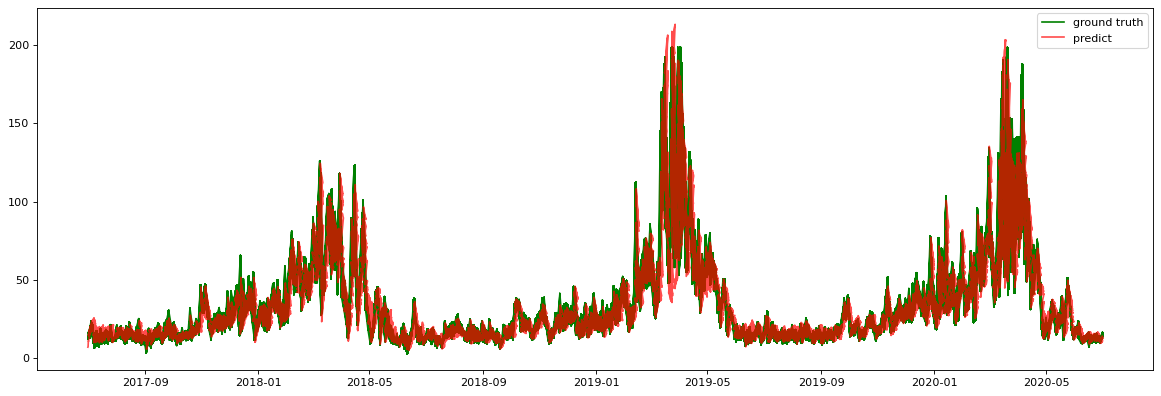

In [20]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

#### Dump PM2.5 model and exog models

In [21]:
with open('./model_save/chiangmai/model_cnx.model',"wb") as f:
    pickle.dump(model, f)

with open('./model_save/chiangmai/model_cnx_exog.model',"wb") as f:
    pickle.dump(model_exog, f)

#### Load PM2.5 model and exog models

In [22]:
model = pickle.load(open('./model_save/chiangmai/model_cnx.model', 'rb'))
model_exog = pickle.load(open('./model_save/chiangmai/model_cnx_exog.model', 'rb'))

### Predict on test set

In [23]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([5e-7, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999875,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [09:35<00:00,  4.83it/s]

ITER#0  RMSE:11.908407109663573


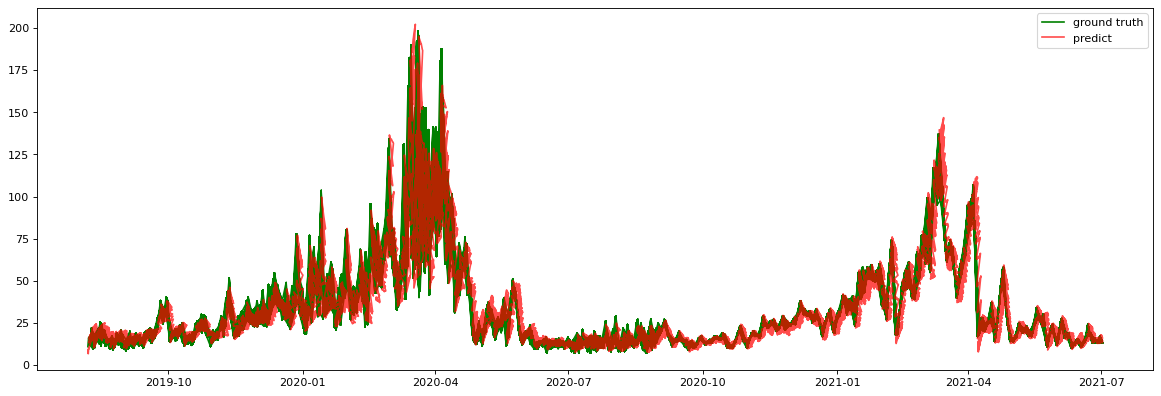

In [24]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [25]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_CNX.csv')